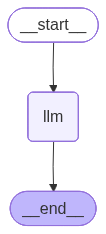

In [1]:
import operator
from typing import Annotated, TypedDict

from IPython.display import Image
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.graph import END, StateGraph
from pprint import pprint


class TestAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


@tool
def find_sum(x: int, y: int) -> int:
    # The docstring comment describes the capabilities of the function
    # It is used by the agent to discover the function's inputs, outputs and capabilities
    """
    This function is used to add two numbers and return their sum.
    It takes two integers as inputs and returns an integer as output.
    """
    return x + y


class TestAgent:
    def __init__(self, model, tools, system_prompt=None, debug=True):
        self.system_prompt = system_prompt
        self.debug = debug
        self.model = model.bind_tools(tools)

        agent_graph = StateGraph(TestAgentState)
        agent_graph.add_node("llm", self.call_llm)
        agent_graph.add_edge("llm", END)
        # Set where there graph starts
        agent_graph.set_entry_point("llm")

        self.agent_graph = agent_graph.compile()

    def call_llm(self, state: TestAgentState):
        messages = state["messages"]

        # If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages

        # invoke the model with the message history
        result = self.model.invoke(messages)
        if self.debug:
            print("\nLLM Returned :")
            pprint(result)
        # Return the LLM output
        return {"messages": [result]}


system_prompt = """
    You are a math genius
    """

model = ChatOllama(model="llama3.2")
tools = [find_sum]

agent = TestAgent(model, tools, system_prompt)
Image(agent.agent_graph.get_graph().draw_mermaid_png())

In [2]:
input = "what is the sum of 12 and 20?"

user_message = {"messages":[HumanMessage(input)]}
ai_response = agent.agent_graph.invoke(user_message)
#Print the response
print(f"\nAGENT : {ai_response['messages'][-1].content}")


LLM Returned :
AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-09-19T02:08:18.946145Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3151102125, 'load_duration': 2205515125, 'prompt_eval_count': 202, 'prompt_eval_duration': 537131625, 'eval_count': 23, 'eval_duration': 406325292, 'model_name': 'llama3.2'}, id='run--90499252-a17a-4118-a989-2ee87e5afcf1-0', tool_calls=[{'name': 'find_sum', 'args': {'x': '12', 'y': '20'}, 'id': '47ee6d89-7711-4614-9422-2c7596b9b23c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 202, 'output_tokens': 23, 'total_tokens': 225})

AGENT : 
